# Installs & Imports

In [1]:
!pip install -q pymc pytensor

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.discrete.discrete_model import MNLogit
from scipy import stats

# Data Generation

In [3]:
def simulate_ordinal_data(
    n: int,
    seed: int = 42
) -> pd.DataFrame:
    """
    Generate a DataFrame with:
      - A 7-level ordinal outcome (0..6) under
        logit(P(Y <= j)) = alpha_j + x_i * gamma_j
      - Two predictors: Age (continuous) and Treatment (binary).
    """
    np.random.seed(seed)
    age = np.random.normal(loc=60, scale=15, size=n)
    age_z = (age - age.mean()) / age.std()
    treatment = np.random.binomial(n=1, p=0.5, size=n)

    # Define 6 cutpoints (must be strictly increasing)
    true_alphas = np.array([-2.0, -1.0, 0.0, 1.0, 2.0, 3.0])

    # Define threshold-specific slopes: shape = (6 thresholds, 2 predictors)
    true_betas = np.array([
        [1.0, -0.5],
        [0.8, -0.2],
        [0.5, 0.0],
        [0.2, 0.3],
        [-0.3, 0.5],
        [-0.8, 1.0],
    ])

    # Flip sign so that logit(P <= j) = alpha_j + x * gamma_j
    true_gammas = -true_betas   # shape (6, 2)
    X = np.column_stack([age_z, treatment])  # shape (n, 2)
    eta = X.dot(true_gammas.T)  # shape (n, 6)

    def draw_ordered(
        eta_mat: np.ndarray,
        alphas: np.ndarray
    ) -> np.ndarray:
        """
        Draw each Y_i from a non-proportional ordered logit:
        P(Y_i = j) = sigmoid(alpha_j + eta_{i,j}) - sigmoid(alpha_{j-1} + eta_{i,j-1})
        with alpha_0 = -infinity, alpha_7 = +infinity.
        """
        n_obs, n_thr = eta_mat.shape  # n_thr == 6
        y = np.zeros(n_obs, dtype="int32")

        for i in range(n_obs):
            # (1) Compute logits = alpha_j + eta_{i,j}  for j=1..6
            logits = alphas + eta_mat[i]   # length 6

            # (2) Clip logits for numerical stability
            logits = np.clip(logits, -500, 500)

            # (3) Compute CDFs: sigmoid(logits) = P(Y_i <= j)
            cdfs = 1.0 / (1.0 + np.exp(-logits))

            # (4) Enforce monotonicity in case of numeric noise
            cdfs = np.maximum.accumulate(cdfs)

            # (5) Build full CDF array: [0, cdfs[0], ..., cdfs[5], 1]
            cdfs_full = np.concatenate(([0.0], cdfs, [1.0]))  # length 8

            # (6) Compute PMF over 7 categories: pmf[j] = cdfs_full[j+1] - cdfs_full[j]
            pmf = cdfs_full[1:] - cdfs_full[:-1]  # length 7

            # (7) Avoid tiny negative probabilities
            pmf = np.maximum(pmf, 1e-10)

            # (8) Normalize so it sums to 1
            pmf = pmf / pmf.sum()

            # (9) Sample category j = argmax of one-hot draw
            y[i] = np.argmax(np.random.multinomial(1, pmf))

        return y

    y = draw_ordered(eta, true_alphas)

    df = pd.DataFrame({
        "Severity": y,
        "Age": age,
        "Age_z": age_z,
        "Treatment": treatment
    })

    return df

In [4]:
# Call simulate_ordinal_data and split
df = simulate_ordinal_data(n=2000, seed=42)
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Severity"]
)

In [5]:
# View the distributions
print("Train size:", train_df.shape[0])
print("Test size:", test_df.shape[0])
print("\nSeverity distribution (Train):")
counts = train_df["Severity"].value_counts().sort_index()
severity_df = (
    counts
    .rename_axis("Severity")
    .reset_index(name="Count")
)
display(severity_df)

Train size: 1600
Test size: 400

Severity distribution (Train):


,Severity,Count
0,0,286
1,1,194
2,2,299
3,3,320
4,4,253
5,5,106
6,6,142


In [6]:
# Check for null and infinite values
print("Null Values:")
print(train_df.isnull().sum())
print()
print("Infinite Values:")
print(train_df.isin([np.inf, -np.inf]).sum())

Null Values:
Severity     0
Age          0
Age_z        0
Treatment    0
dtype: int64

Infinite Values:
Severity     0
Age          0
Age_z        0
Treatment    0
dtype: int64


# Oracle Performance

In [7]:
# True parameters used in data generation
TRUE_ALPHAS = np.array([-2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
TRUE_BETAS = np.array([
    [ 1.0, -0.5],  # beta1  (for alpha1 = -2.0)
    [ 0.8, -0.2],  # beta2  (for alpha2 = -1.0)
    [ 0.5, 0.0],   # beta3  (for alpha3 =  0.0)
    [ 0.2, 0.3],   # beta4  (for alpha4 =  1.0)
    [-0.3, 0.5],   # beta5  (for alpha5 =  2.0)
    [-0.8, 1.0],   # beta6  (for alpha6 =  3.0)
])

In [8]:
def oracle_predict(
    X: np.ndarray,
    alphas: np.ndarray,
    betas: np.ndarray
) -> np.ndarray:
    """
    Oracle (Bayes-optimal) classifier for the simulated ordinal data.
    Given the true alphas (thresholds) and true betas (threshold-specific slopes),
    it computes for each x_i the exact P(Y_i = j) and picks argmax_j P(Y_i = j).
    The resulting fraction correct is the theoretical maximum accuracy expected
    on these data.

    Given:
      - X: array of shape (n_obs, 2) containing [Age_z, Treatment]
      - alphas: array of shape (6,) containing the six thresholds
      - betas: array of shape (6, 2) containing threshold-specific slopes

    Returns:
      - preds: array of shape (n_obs,), the oracle's argmax_j P(Y=j | x_i).
    """
    # (1) Compute eta = X dot betas.T -> shape (n_obs, 6)
    eta = X.dot(betas.T)

    # (2) logits = alpha[j] - eta[i, j] for all i, j -> shape (n_obs, 6)
    logits = alphas.reshape(1, -1) - eta
    logits = np.clip(logits, -500, 500)

    # (3) cdfs = sigmoid(logits) = P(Y_i <= j) for j = 0..5 -> shape (n_obs, 6)
    cdfs = 1.0 / (1.0 + np.exp(-logits))

    # (4) Pad with 0 and 1 to form cdfs_full -> shape (n_obs, 8)
    zeros = np.zeros((X.shape[0], 1))
    ones = np.ones((X.shape[0], 1))
    cdfs_full = np.concatenate([zeros, cdfs, ones], axis=1)

    # (5) pmf over 7 categories = differences of successive cdfs_full -> shape (n_obs, 7)
    pmf = cdfs_full[:, 1:] - cdfs_full[:, :-1]
    pmf = np.clip(pmf, 0.0, None)
    pmf = pmf / pmf.sum(axis=1, keepdims=True)

    # (6) Oracle prediction = argmax_j pmf[i, j]
    preds = np.argmax(pmf, axis=1)
    return preds

In [9]:
# Separate the train/test sets
X_train = train_df[["Age_z", "Treatment"]].values
y_train = train_df["Severity"].values
X_test = test_df[["Age_z", "Treatment"]].values
y_test = test_df["Severity"].values

In [10]:
# Compute Oracle predictions
oracle_train_preds = oracle_predict(X_train, TRUE_ALPHAS, TRUE_BETAS)
oracle_test_preds = oracle_predict(X_test, TRUE_ALPHAS, TRUE_BETAS)

# Measure accuracy
oracle_train_acc = accuracy_score(y_train, oracle_train_preds)
oracle_test_acc = accuracy_score(y_test, oracle_test_preds)

print(f"Oracle accuracy on TRAIN set: {oracle_train_acc:.3f}")
print(f"Oracle accuracy on TEST set: {oracle_test_acc:.3f}")

Oracle accuracy on TRAIN set: 0.276
Oracle accuracy on TEST set: 0.285


In [11]:
# Compare to a trivial baseline that always predicts the most frequent category
most_common = df["Severity"].mode().iloc[0]
baseline_train_acc = accuracy_score(y_train, np.full_like(y_train, most_common))
baseline_test_acc = accuracy_score(y_test, np.full_like(y_test, most_common))

print(f"Baseline (mode={most_common}) accuracy on TRAIN: {baseline_train_acc:.3f}")
print(f"Baseline (mode={most_common}) accuracy on TEST: {baseline_test_acc:.3f}")

Baseline (mode=3) accuracy on TRAIN: 0.200
Baseline (mode=3) accuracy on TEST: 0.200


# PyMC Parameters

In [12]:
# Set parameters
N_DRAWS = 7500
N_TUNE = 2500
TARGET_ACCEPT = 0.99
MAX_TREEDEPTH = 12

# Proportional Odds Model

In [13]:
# Proportional Odds Model (POM)
def fit_proportional_odds(
    train_df: pd.DataFrame,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    target_accept: float = 0.9,
    max_treedepth: int = 10
) -> pm.backends.base.MultiTrace:
    """
    Fit a Proportional Odds Model in PyMC.
    """
    with pm.Model() as model:
        # Base location for the first cutpoint
        alpha_0 = pm.Normal("alpha_0", mu=0, sigma=2)

        # Five strictly positive gaps delta_0..delta_4 so that:
        # raw_alphas = [
        #     alpha_0,
        #     alpha_0 + delta[0],
        #     alpha_0 + delta[0] + delta[1],
        #     alpha_0 + delta[0] + delta[1] + delta[2],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3] + delta[4]
        # ]
        delta = pm.HalfNormal("delta", sigma=1, shape=5)

        increments = pm.math.stack(
            [alpha_0 + pm.math.sum(delta[:i]) for i in range(1, 6)]
        )

        alpha0_vec = pm.math.stack([alpha_0])
        raw_alphas = pm.math.concatenate([alpha0_vec, increments], axis=0)

        # Clip cutpoints
        alphas = pm.Deterministic("alphas", var=pm.math.clip(raw_alphas, -15, 15))

        # Regression coefficients (shared across all thresholds)
        beta = pm.Normal("beta", mu=0, sigma=2, shape=2)

        # Extract predictor matrix
        X = train_df[["Age_z", "Treatment"]].to_numpy()

        # Linear predictor and clipping
        raw_eta = pt.dot(X, beta)
        eta = pm.Deterministic("eta", var=pm.math.clip(raw_eta, -15, 15))

        # Likelihood
        pm.OrderedLogistic(
            name="y_obs",
            eta=eta,
            cutpoints=alphas,
            observed=train_df["Severity"].to_numpy()
        )

        # Sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            max_treedepth=max_treedepth,
            return_inferencedata=False
        )

    return trace

In [14]:
# Call fit_proportional_odds
trace_pom = fit_proportional_odds(
    train_df,
    draws=N_DRAWS,
    tune=N_TUNE,
    target_accept=TARGET_ACCEPT,
    max_treedepth=MAX_TREEDEPTH
)
print("POM fitting complete.")

Output()

POM fitting complete.


# Non-Proportional Odds Model

In [15]:
# Non-Proportional Odds Model (NPOM)
def fit_nonproportional_odds(
    train_df: pd.DataFrame,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    target_accept: float = 0.9,
    max_treedepth: int = 10
) -> pm.backends.base.MultiTrace:
    """
    Fit a Non-Proportional Odds Model in PyMC.
    """
    with pm.Model() as model:
        # Base location for the first cutpoint
        alpha_0 = pm.Normal("alpha_0", mu=0, sigma=2)

        # Five strictly positive gaps delta_0..delta_4 so that:
        # raw_alphas = [
        #     alpha_0,
        #     alpha_0 + delta[0],
        #     alpha_0 + delta[0] + delta[1],
        #     alpha_0 + delta[0] + delta[1] + delta[2],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3] + delta[4]
        # ]
        delta = pm.HalfNormal("delta", sigma=1, shape=5)

        increments = pm.math.stack(
            [alpha_0 + pm.math.sum(delta[:i]) for i in range(1, 6)]
        )

        alpha0_vec = pm.math.stack([alpha_0])
        raw_alphas = pm.math.concatenate([alpha0_vec, increments], axis=0)

        # Clip cutpoints
        alphas = pm.Deterministic("alphas", var=pm.math.clip(raw_alphas, -15, 15))

        # Threshold-specific regression coefficients
        betas = pm.Normal("betas", mu=0, sigma=2, shape=(6, 2))

        # Extract predictor matrix
        X = train_df[["Age_z", "Treatment"]].to_numpy()
        n_obs = X.shape[0]

        # Compute raw linear predictors for each threshold
        raw_eta = pt.dot(X, betas.T)  # (n_obs, 6)

        # Build cumulative probabilities threshold by threshold
        cumprobs_list = []
        for j in range(6):
            # Compute raw logit at threshold j
            raw_logit_j = alphas[j] - raw_eta[:, j]

            # Clip logit
            logit_j = pm.math.clip(raw_logit_j, -15, 15)

            # Sigmoid to get probability
            prob_j = pm.math.sigmoid(logit_j)

            if j == 0:
                cumprobs_list.append(prob_j)
            else:
                # Enforce monotonicity: cumprobs[j] >= cumprobs[j-1]
                cumprobs_list.append(pm.math.maximum(prob_j, cumprobs_list[j - 1]))

        cumprobs_stacked = pm.math.stack(cumprobs_list, axis=1)

        # Add boundaries
        zeros = pt.zeros((n_obs, 1))
        ones = pt.ones((n_obs, 1))
        cumprobs_with_bounds = pm.math.concatenate(
            [zeros, cumprobs_stacked, ones],
            axis=1
        )

        # Compute category probabilities by differencing adjacent cumulative probabilities
        probs = cumprobs_with_bounds[:, 1:] - cumprobs_with_bounds[:, :-1]

        # Add a small value to avoid exact zeros, then renormalize
        probs_safe = probs + 1e-8
        probs_normalized = probs_safe / pm.math.sum(probs_safe, axis=1, keepdims=True)

        # Likelihood
        pm.Categorical(
            name="y_obs",
            p=probs_normalized,
            observed=train_df["Severity"].to_numpy()
        )

        # Sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            max_treedepth=max_treedepth,
            return_inferencedata=False
        )

    return trace

In [16]:
# Call fit_nonproportional_odds
trace_npom = fit_nonproportional_odds(
    train_df,
    draws=N_DRAWS,
    tune=N_TUNE,
    target_accept=TARGET_ACCEPT,
    max_treedepth=MAX_TREEDEPTH
)
print("NPOM fitting complete.")

Output()

ERROR:pymc.stats.convergence:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


NPOM fitting complete.


# Partial Proportional Odds Model

In [17]:
# Partial Proportional Odds Model (PPOM)
def fit_partial_proportional_odds(
    train_df: pd.DataFrame,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    target_accept: float = 0.9,
    max_treedepth: int = 10
) -> pm.backends.base.MultiTrace:
    """
    Fit a Partial Proportional Odds Model in PyMC.
    """
    # Extract the predictor matrix
    X = train_df[["Age_z", "Treatment"]].to_numpy()
    age_z = X[:, 0]  # vector for predictor
    trt = X[:, 1]    # vector for predictor
    n_obs = age_z.shape[0]  # number of observations

    with pm.Model() as model:
        # Build six ordered cutpoints:
        # raw_alphas = [
        #     alpha_0,
        #     alpha_0 + delta[0],
        #     alpha_0 + delta[0] + delta[1],
        #     alpha_0 + delta[0] + delta[1] + delta[2],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3],
        #     alpha_0 + delta[0] + delta[1] + delta[2] + delta[3] + delta[4]
        # ]
        alpha_0 = pm.Normal("alpha_0", mu=0, sigma=2)
        delta = pm.HalfNormal("delta", sigma=1, shape=5)

        increments = pm.math.stack(
            [alpha_0 + pm.math.sum(delta[:i]) for i in range(1, 6)]
        )

        alpha0_vec = pm.math.stack([alpha_0])
        raw_alphas = pm.math.concatenate([alpha0_vec, increments], axis=0)

        # Clip cutpoints
        alphas = pm.Deterministic("alphas", var=pm.math.clip(raw_alphas, -15, 15))

        # Slope parameters
        beta_age = pm.Normal("beta_age", mu=0, sigma=2, shape=6)
        beta_trt = pm.Normal("beta_trt", mu=0, sigma=2)

        # Build raw logits and raw CDFs
        raw_logits = []
        for j in range(6):
            lin_part = age_z * beta_age[j] + trt * beta_trt
            raw_logit_j = alphas[j] - lin_part
            logit_j = pm.math.clip(raw_logit_j, -15, 15)
            raw_logits.append(logit_j)

        raw_logits_stacked = pm.math.stack(raw_logits, axis=1)
        raw_cdfs = pm.math.sigmoid(raw_logits_stacked)

        # Enforce monotonicity via max
        cumprobs = [raw_cdfs[:, 0]]
        for j in range(1, 6):
            cumprobs.append(pt.maximum(raw_cdfs[:, j], cumprobs[j - 1]))
        cumprobs_stacked = pt.stack(cumprobs, axis=1)

        # Add boundaries
        zeros = pt.zeros((n_obs, 1))
        ones = pt.ones((n_obs, 1))
        cumprobs_with_bounds = pm.math.concatenate(
            [zeros, cumprobs_stacked, ones],
            axis=1
        )

        # Compute 7-category probabilities
        probs_raw = cumprobs_with_bounds[:, 1:] - cumprobs_with_bounds[:, :-1]
        probs_safe = probs_raw + 1e-8
        probs = probs_safe / pm.math.sum(probs_safe, axis=1, keepdims=True)

        # Likelihood
        pm.Categorical(
            name="y_obs",
            p=probs,
            observed=train_df["Severity"].to_numpy()
        )

        # Sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            max_treedepth=max_treedepth,
            init="jitter+adapt_diag",  # default
            step_scale=0.25,           # default
            return_inferencedata=False
        )

    return trace

In [18]:
# Call fit_partial_proportional_odds
trace_ppom = fit_partial_proportional_odds(
    train_df,
    draws=N_DRAWS,
    tune=N_TUNE,
    target_accept=TARGET_ACCEPT,
    max_treedepth=MAX_TREEDEPTH
)
print("PPOM fitting complete.")

Output()

ERROR:pymc.stats.convergence:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


PPOM fitting complete.


# Per-Threshold Logit Model

In [19]:
# Independent Threshold Logit Model (ITL)
def fit_independent_threshold_logit(
    train_df: pd.DataFrame,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    target_accept: float = 0.9,
    max_treedepth: int = 10,
    enforce_monotonicity: bool = False
) -> pm.backends.base.MultiTrace:
    """
    Fit an Independent Threshold Logit Model in PyMC.
    Each threshold j = 0..5 has its own binary logistic regression.
    logit(P(Y <= j)) = alpha[j] + Age_z * beta[j,0] + Treatment * beta[j,1].
    """
    # Extract observed outcomes
    y = train_df["Severity"].to_numpy()
    n_obs = y.shape[0]

    # Build binary indicators: Y_bin[i, j] = 1 if y[i] <= j else 0
    Y_bin = np.stack([(y <= j).astype("int32") for j in range(6)], axis=1)

    # Extract the predictor matrix
    X = train_df[["Age_z", "Treatment"]].to_numpy()

    with pm.Model() as model:
        # Priors for intercepts and slopes
        alpha = pm.Normal("alpha", mu=0, sigma=5, shape=6)
        beta = pm.Normal("beta", mu=0, sigma=2, shape=(6, 2))

        # Linear predictor per threshold and clipping
        raw_eta = alpha + pt.dot(X, beta.T)
        eta = pm.math.clip(raw_eta, -15, 15)

        # Convert to probabilities P(Y <= j)
        p_raw = pm.math.sigmoid(eta)

        # Optionally enforce monotonicity
        if enforce_monotonicity:
            p_list = [p_raw[:, 0]]
            for j in range(1, 6):
                p_list.append(pt.maximum(p_raw[:, j], p_list[j - 1]))
            p = pt.stack(p_list, axis=1)
        else:
            p = p_raw

        # Likelihood: independent Bernoulli at each threshold
        pm.Bernoulli(
            name="y_obs",
            p=p,
            observed=Y_bin
        )

        # Sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            max_treedepth=max_treedepth,
            return_inferencedata=False
        )

    return trace

In [20]:
# Call fit_independent_threshold_logit
trace_itl = fit_independent_threshold_logit(
    train_df,
    draws=N_DRAWS,
    tune=N_TUNE,
    target_accept=TARGET_ACCEPT,
    max_treedepth=MAX_TREEDEPTH
)
print("ITL fitting complete.")

Output()

ITL fitting complete.


# Multinomial Logit Model

In [21]:
# Multinomial Logit Model (MNL)
def fit_multinomial_logit(
    train_df: pd.DataFrame,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    target_accept: float = 0.9,
    max_treedepth: int = 10
) -> pm.backends.base.MultiTrace:
    """
    Fit a multinomial logit model (MNL) in PyMC.
    """
    with pm.Model() as model:
        # Number of categories and predictors
        K = 7
        P = 2

        # Intercepts for categories 1-6 (category 0 is reference)
        alpha_mnl = pm.Normal(
            name="alpha_mnl",
            mu=0,
            sigma=5,
            shape=K - 1
        )

        # Coefficients for categories 1-6
        beta_mnl = pm.Normal(
            name="beta_mnl",
            mu=0,
            sigma=3,
            shape=(K - 1, P)
        )

        # Extract the predictor matrix
        X_train = train_df[["Age_z", "Treatment"]].to_numpy()
        n_obs = train_df.shape[0]

        # Build logits matrix
        # First category (0) is reference with logit = 0
        logits_list = [pt.zeros(n_obs)]

        for j in range(K - 1):
            linear_term = alpha_mnl[j] + pt.dot(X_train, beta_mnl[j])
            logits_list.append(linear_term)

        # Stack to create (n_obs, K) matrix
        logits = pt.stack(logits_list, axis=1)

        # Likelihood
        pm.Categorical(
            name="y_obs_mnl",
            logit_p=logits,
            observed=train_df["Severity"].to_numpy()
        )

        # Sampling
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            max_treedepth=max_treedepth,
            return_inferencedata=False
        )

    return trace

In [22]:
# Call fit_multinomial_logit
trace_mnl = fit_multinomial_logit(
    train_df,
    draws=N_DRAWS,
    tune=N_TUNE,
    target_accept=TARGET_ACCEPT,
    max_treedepth=MAX_TREEDEPTH
)
print("MNL fitting complete.")

Output()

MNL fitting complete.


# Posterior Means

In [23]:
def extract_pom_means(
    trace: pm.backends.base.MultiTrace
) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract posterior-mean beta and alphas for POM.
    """
    beta_samples = trace.get_values(
        "beta",
        combine=True
    )

    alphas_samples = trace.get_values(
        "alphas",
        combine=True
    )

    beta_mean = beta_samples.mean(axis=0)
    alphas_mean = alphas_samples.mean(axis=0)

    return beta_mean, alphas_mean

In [24]:
# Extract POM means
beta_pom_mean, alphas_pom_mean = extract_pom_means(trace_pom)
print("POM posterior means extracted.")

POM posterior means extracted.


In [25]:
def extract_npom_means(
    trace: pm.backends.base.MultiTrace
) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract posterior-mean betas and alphas for NPOM.
    """
    betas_samples = trace.get_values(
        "betas",
        combine=True
    )

    alphas_samples = trace.get_values(
        "alphas",
        combine=True
    )

    betas_mean = betas_samples.mean(axis=0)
    alphas_mean = alphas_samples.mean(axis=0)

    return betas_mean, alphas_mean

In [26]:
# Extract NPOM means
betas_np_mean, alphas_np_mean = extract_npom_means(trace_npom)
print("NPOM posterior means extracted.")

NPOM posterior means extracted.


In [27]:
def extract_ppom_means(
    trace: pm.backends.base.MultiTrace
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Extract posterior-mean beta_age, beta_trt, and alphas for PPOM.
    """
    beta_age_samples = trace.get_values(
        "beta_age",
        combine=True
    )

    beta_trt_samples = trace.get_values(
        "beta_trt",
        combine=True
    )

    alphas_samples = trace.get_values(
        "alphas",
        combine=True
    )

    beta_age_mean = beta_age_samples.mean(axis=0)
    beta_trt_mean = beta_trt_samples.mean(axis=0)
    alphas_mean = alphas_samples.mean(axis=0)

    return beta_age_mean, beta_trt_mean, alphas_mean

In [28]:
# Extract PPOM means
beta_age_ppom_mean, beta_trt_ppom_mean, alphas_ppom_mean = extract_ppom_means(trace_ppom)
print("PPOM posterior means extracted.")

PPOM posterior means extracted.


In [29]:
def extract_itl_means(
    trace: pm.backends.base.MultiTrace
) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract posterior-mean alpha and beta for ITL.
    """
    alpha_samples = trace.get_values(
        "alpha",
        combine=True
    )

    beta_samples = trace.get_values(
        "beta",
        combine=True
    )

    alpha_mean = alpha_samples.mean(axis=0)
    beta_mean = beta_samples.mean(axis=0)

    return alpha_mean, beta_mean

In [30]:
# Extract ITL means
alpha_itl_mean, beta_itl_mean = extract_itl_means(trace_itl)
print("ITL posterior means extracted.")

ITL posterior means extracted.


In [31]:
def extract_mnl_means(
    trace: pm.backends.base.MultiTrace
) -> tuple[np.ndarray, np.ndarray]:
    """
    Extract posterior-mean alpha_mnl and beta_mnl for MNL.
    """
    alpha_mnl_samples = trace.get_values(
        "alpha_mnl",
        combine=True
    )

    beta_mnl_samples = trace.get_values(
        "beta_mnl",
        combine=True
    )

    alpha_mnl_mean = alpha_mnl_samples.mean(axis=0)
    beta_mnl_mean = beta_mnl_samples.mean(axis=0)

    return alpha_mnl_mean, beta_mnl_mean

In [32]:
# Extract MNL means
alpha_mnl_mean, beta_mnl_mean = extract_mnl_means(trace_mnl)
print("MNL posterior means extracted.")

MNL posterior means extracted.


# Predictive Evaluation

In [33]:
def ordered_logistic_probs(
    eta_vec: np.ndarray,
    alphas_vec: np.ndarray,
    is_npom: bool = False
) -> np.ndarray:
    """
    Return an (n_obs, 7) array of probabilities for ordered logits.
    For NPOM, eta_vec should be (n_obs, 6) and is_npom=True.
    For POM, eta_vec should be (n_obs,) and is_npom=False.
    """
    n_obs = eta_vec.shape[0]
    K = alphas_vec.shape[0] + 1
    probs = np.zeros((n_obs, K))

    for i in range(n_obs):
        if is_npom:
            # For NPOM: eta_vec[i, :] has shape (6,), alphas_vec has shape (6,)
            # Each threshold has its own linear predictor
            eta_i = eta_vec[i, :]
            logits = alphas_vec - eta_i
        else:
            # For POM: eta_vec[i] is scalar, same linear predictor for all thresholds
            eta_i = eta_vec[i]
            logits = alphas_vec - eta_i

        # Clip to prevent overflow
        logits = np.clip(logits, -500, 500)
        cdfs = 1 / (1 + np.exp(-logits))

        # Ensure monotonicity for valid probabilities
        cdfs = np.maximum.accumulate(cdfs)

        cdfs_full = np.concatenate([[0.0], cdfs, [1.0]])
        pmf = cdfs_full[1:] - cdfs_full[:-1]

        # Ensure valid probabilities
        pmf = np.maximum(pmf, 1e-10)
        probs[i] = pmf / pmf.sum()

    return probs

## Training Set

In [34]:
# Predictor matrix
X_train = train_df[["Age_z", "Treatment"]].to_numpy()
n_train = X_train.shape[0]  # number of observations

In [35]:
# POM training set evaluation
# Compute raw linear predictor
eta_train_pom = X_train.dot(beta_pom_mean)

# Compute ordered logit probabilities (n_obs x 7)
pom_probs_train = ordered_logistic_probs(
    eta_train_pom,
    alphas_pom_mean
)

# Select the most likely category for each observation
pom_train_preds = np.argmax(pom_probs_train, axis=1)

# Compute accuracy
pom_train_acc = accuracy_score(
    train_df["Severity"],
    pom_train_preds
)

In [36]:
# NPOM training set evaluation
# Compute threshold-specific linear predictors
eta_train_np = X_train.dot(betas_np_mean.T)

# Compute ordered logit probabilities (n_obs x 7)
npom_probs_train = ordered_logistic_probs(
    eta_train_np,
    alphas_np_mean,
    is_npom=True
)

# Select the most likely category for each observation
npom_train_preds = np.argmax(npom_probs_train, axis=1)

# Compute accuracy
npom_train_acc = accuracy_score(
    train_df["Severity"],
    npom_train_preds
)

In [37]:
# PPOM training set evaluation
# Build the slope matrix from the two posterior-mean vectors
#   beta_age_ppom_mean; shape = (6,)
#   beta_trt_ppom_mean; scalar
betas_ppom_mean = np.column_stack([
    beta_age_ppom_mean,
    np.repeat(beta_trt_ppom_mean, 6)
])

# Compute threshold-specific linear predictors (n_obs x 6)
eta_train_ppom = X_train.dot(betas_ppom_mean.T)

# Get array of probabilities (n_obs x 7)
# Pass is_npom=True so each threshold has its own linear predictor
ppom_probs_train = ordered_logistic_probs(
    eta_train_ppom,
    alphas_ppom_mean,
    is_npom=True
)

# Select the most likely category for each observation
ppom_train_preds = np.argmax(ppom_probs_train, axis=1)

# Compute accuracy
ppom_train_acc = accuracy_score(
    train_df["Severity"],
    ppom_train_preds
)

In [38]:
# ITL training set evaluation
# Compute raw logits for each threshold j=0..5:
#   logit(P(Y <= j)) = alpha_itl_mean[j] + X_train.dot(beta_itl_mean[j])
#   overall shape = (n_train, 6)
logits_train_itl = alpha_itl_mean + X_train.dot(beta_itl_mean.T)

# Clip to avoid overflow
logits_train_itl = np.clip(logits_train_itl, -500, 500)

# Convert to cumulative probabilities via sigmoid
cdfs_itl = 1.0 / (1.0 + np.exp(-logits_train_itl))

# Enforce monotonicity: P(Y <= j) >= P(Y <= j-1)
cdfs_itl = np.maximum.accumulate(cdfs_itl, axis=1)

# Add 0 at j=-1 and 1 at j=6 to form full CDF
cdfs_full_itl = np.concatenate([
    np.zeros((n_train, 1)),
    cdfs_itl,
    np.ones((n_train, 1))
], axis=1)

# Category probabilities by adjacent differences; shape = (n_train, 7)
probs_itl_train = cdfs_full_itl[:, 1:] - cdfs_full_itl[:, :-1]

# Renormalize
probs_itl_train /= probs_itl_train.sum(axis=1, keepdims=True)

# Select the most likely category for each observation
itl_train_preds = np.argmax(probs_itl_train, axis=1)

# Compute accuracy
itl_train_acc = accuracy_score(
    train_df["Severity"],
    itl_train_preds
)

In [39]:
# MNL training set evaluation
# Initialize logits matrix
#   zeros for category 0, fill categories 1..6
#   logits_train; shape = (n_train, 7)
logits_train = np.zeros((n_train, 7))

# Fill logits for categories 1..6:
#   logits_train[:, j+1] = alpha_mnl_mean[j] + X_train dot beta_mnl_mean[j].T
for j in range(6):
    logits_train[:, j + 1] = (
        alpha_mnl_mean[j] + X_train.dot(beta_mnl_mean[j].T)
    )

# Convert logits to probabilities via softmax
exp_logits_train = np.exp(logits_train)
mnl_probs_train = exp_logits_train / exp_logits_train.sum(
    axis=1,
    keepdims=True
)

# Select the most likely category for each observation
mnl_train_preds = np.argmax(mnl_probs_train, axis=1)

# Compute accuracy
mnl_train_acc = accuracy_score(
    train_df["Severity"],
    mnl_train_preds
)

In [40]:
# Training set accuracies
print("=== Training Set Accuracy ===")
print(f"POM: {pom_train_acc:.4f}")
print(f"NPOM: {npom_train_acc:.4f}")
print(f"PPOM: {ppom_train_acc:.4f}")
print(f"ITL: {itl_train_acc:.4f}")
print(f"MNL: {mnl_train_acc:.4f}")

=== Training Set Accuracy ===
POM: 0.2681
NPOM: 0.2863
PPOM: 0.2744
ITL: 0.2838
MNL: 0.2825


## Test Set

In [41]:
# Predictor matrix
X_test = test_df[["Age_z", "Treatment"]].to_numpy()
n_test = X_test.shape[0]  # number of observations

In [42]:
# POM test set evaluation
# Compute raw linear predictor
eta_test_pom = X_test.dot(beta_pom_mean)

# Compute ordered logit probabilities (n_obs x 7)
pom_probs_test = ordered_logistic_probs(
    eta_test_pom,
    alphas_pom_mean
)

# Select the most likely category for each observation
pom_test_preds = np.argmax(pom_probs_test, axis=1)

# Compute accuracy
pom_test_acc = accuracy_score(
    test_df["Severity"],
    pom_test_preds
)

In [43]:
# NPOM test set evaluation
# Compute threshold-specific linear predictors
eta_test_np = X_test.dot(betas_np_mean.T)

# Compute ordered logit probabilities (n_obs x 7)
npom_probs_test = ordered_logistic_probs(
    eta_test_np,
    alphas_np_mean,
    is_npom=True
)

# Select the most likely category for each observation
npom_test_preds = np.argmax(npom_probs_test, axis=1)

# Compute accuracy
npom_test_acc = accuracy_score(
    test_df["Severity"],
    npom_test_preds
)

In [44]:
# PPOM test set evaluation
# Build the slope matrix from the two posterior-mean vectors
#   beta_age_ppom_mean; shape = (6,)
#   beta_trt_ppom_mean; scalar
betas_ppom_mean = np.column_stack([
    beta_age_ppom_mean,
    np.repeat(beta_trt_ppom_mean, 6)
])

# Compute threshold-specific linear predictors (n_obs x 6)
eta_test_ppom = X_test.dot(betas_ppom_mean.T)

# Get array of probabilities (n_obs x 7)
# Pass is_npom=True so each threshold has its own linear predictor
ppom_probs_test = ordered_logistic_probs(
    eta_test_ppom,
    alphas_ppom_mean,
    is_npom=True
)

# Select the most likely category for each observation
ppom_test_preds = np.argmax(ppom_probs_test, axis=1)

# Compute accuracy
ppom_test_acc = accuracy_score(
    test_df["Severity"],
    ppom_test_preds
)

In [45]:
# ITL test set evaluation
# Compute raw logits for each threshold j=0..5:
#   logit(P(Y <= j)) = alpha_itl_mean[j] + X_test.dot(beta_itl_mean[j])
#   overall shape = (n_test, 6)
logits_test_itl = alpha_itl_mean + X_test.dot(beta_itl_mean.T)

# Clip to avoid overflow
logits_test_itl = np.clip(logits_test_itl, -500, 500)

# Convert to cumulative probabilities via sigmoid
cdfs_itl = 1.0 / (1.0 + np.exp(-logits_test_itl))

# Enforce monotonicity: P(Y <= j) >= P(Y <= j-1)
cdfs_itl = np.maximum.accumulate(cdfs_itl, axis=1)

# Add 0 at j=-1 and 1 at j=6 to form full CDF
cdfs_full_itl = np.concatenate([
    np.zeros((n_test, 1)),
    cdfs_itl,
    np.ones((n_test, 1))
], axis=1)

# Category probabilities by adjacent differences; shape = (n_test, 7)
probs_itl_test = cdfs_full_itl[:, 1:] - cdfs_full_itl[:, :-1]

# Renormalize
probs_itl_test /= probs_itl_test.sum(axis=1, keepdims=True)

# Select the most likely category for each observation
itl_test_preds = np.argmax(probs_itl_test, axis=1)

# Compute accuracy
itl_test_acc = accuracy_score(
    test_df["Severity"],
    itl_test_preds
)

In [46]:
# MNL test set evaluation
# Initialize logits matrix
#   zeros for category 0, fill categories 1..6
#   logits_test; shape = (n_test, 7)
logits_test = np.zeros((n_test, 7))

# Fill logits for categories 1..6:
#   logits_test[:, j+1] = alpha_mnl_mean[j] + X_test dot beta_mnl_mean[j].T
for j in range(6):
    logits_test[:, j + 1] = (
        alpha_mnl_mean[j] + X_test.dot(beta_mnl_mean[j].T)
    )

# Convert logits to probabilities via softmax
exp_logits_test = np.exp(logits_test)
mnl_probs_test = exp_logits_test / exp_logits_test.sum(
    axis=1,
    keepdims=True
)

# Select the most likely category for each observation
mnl_test_preds = np.argmax(mnl_probs_test, axis=1)

# Compute accuracy
mnl_test_acc = accuracy_score(
    test_df["Severity"],
    mnl_test_preds
)

In [47]:
# Test set accuracies
print("=== Test Set Accuracy ===")
print(f"POM: {pom_test_acc:.4f}")
print(f"NPOM: {npom_test_acc:.4f}")
print(f"PPOM: {ppom_test_acc:.4f}")
print(f"ITL: {itl_test_acc:.4f}")
print(f"MNL: {mnl_test_acc:.4f}")

=== Test Set Accuracy ===
POM: 0.2975
NPOM: 0.3100
PPOM: 0.3000
ITL: 0.3075
MNL: 0.3100


## Modular Rewrite

In [48]:
def ordinal_accuracy(
    X: np.ndarray,
    y: np.ndarray,
    beta: np.ndarray,
    alphas: np.ndarray,
    is_npom: bool = False
) -> float:
    """
    Compute accuracy for POM or NPOM:
    - beta: shape = (n_features,) for POM, or (n_thresholds, n_features) for NPOM
    - alphas: shape = (n_thresholds,)
    - is_npom: If True, interpret beta as (n_thresholds, n_features)
    """
    # Compute linear predictors
    if not is_npom:
        # POM: single shared coefficient per feature
        # eta has shape (n_samples,)
        eta = X.dot(beta)
    else:
        # NPOM (or PPOM): distinct coefficients per threshold
        # beta has shape (n_thresholds, n_features)
        # eta has shape (n_samples, n_thresholds)
        eta = X.dot(beta.T)

    # Turn eta and cutpoints into an (n_samples, K) probability matrix
    probs = ordered_logistic_probs(eta, alphas, is_npom=is_npom)

    # Select category with the highest probability for each sample
    preds = np.argmax(probs, axis=1)

    return accuracy_score(y, preds)

In [49]:
def ppom_accuracy(
    X: np.ndarray,
    y: np.ndarray,
    beta_age: np.ndarray,
    beta_trt: float,
    alphas: np.ndarray
) -> float:
    """
    Compute accuracy for PPOM.
    - beta_age: shape = (n_thresholds,)
    - beta_trt: scalar
    - alphas: shape = (n_thresholds,)
    """
    # Build threshold-specific slope matrix; shape = (n_thresholds, n_features)
    betas = np.column_stack([
        beta_age,
        np.repeat(beta_trt, beta_age.shape[0])
    ])

    # Call ordinal_accuracy with is_npom=True
    return ordinal_accuracy(X, y, betas, alphas, is_npom=True)

In [50]:
def itl_accuracy(
    X: np.ndarray,
    y: np.ndarray,
    alpha_itl: np.ndarray,
    beta_itl: np.ndarray
) -> float:
    """
    Compute accuracy for ITL model.
    - alpha_itl: shape = (n_thresholds,)
    - beta_itl: shape = (n_thresholds, n_features)
    """
    # Number of samples
    n_samples = X.shape[0]

    # Compute raw logits for each threshold
    logits = alpha_itl + X.dot(beta_itl.T)

    # Clip to avoid overflow
    logits = np.clip(logits, -500, 500)

    # Convert to cumulative probabilities
    cdfs = 1.0 / (1.0 + np.exp(-logits))

    # Enforce monotonicity: P(Y <= j) >= P(Y <= j-1)
    cdfs = np.maximum.accumulate(cdfs, axis=1)

    # Add boundaries
    cdfs_full = np.concatenate([
        np.zeros((n_samples, 1)),
        cdfs,
        np.ones((n_samples, 1))
    ], axis=1)

    # Category probabilities by adjacent differences
    probs = cdfs_full[:, 1:] - cdfs_full[:, :-1]

    # Renormalize
    probs = probs / probs.sum(axis=1, keepdims=True)

    # Select category with the highest probability for each sample
    preds = np.argmax(probs, axis=1)

    return accuracy_score(y, preds)

In [51]:
def mnl_accuracy(
    X: np.ndarray,
    y: np.ndarray,
    alpha_mnl: np.ndarray,
    beta_mnl: np.ndarray
) -> float:
    """
    Compute accuracy for MNL model:
    - alpha_mnl: shape = (n_classes - 1,)
    - beta_mnl: shape = (n_classes - 1, n_features)
    """
    # Number of examples and classes
    n_samples = X.shape[0]
    n_classes = alpha_mnl.shape[0] + 1

    # Initialize logits matrix (n_samples x n_classes)
    #   column 0 remains 0 for the reference class
    logits = np.zeros((n_samples, n_classes))

    # Fill logits for classes 1..(n_classes-1)
    #   logit for class j+1: alpha_mnl[j] + X dot beta_mnl[j]
    for j in range(n_classes - 1):
        logits[:, j + 1] = alpha_mnl[j] + X.dot(beta_mnl[j].T)

    # Exponentiate logits and normalize to get probabilities
    exp_logits = np.exp(logits)
    probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)

    # Select category with the highest probability for each sample
    preds = np.argmax(probs, axis=1)

    return accuracy_score(y, preds)

In [52]:
def evaluate_model(
    model_name: str,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    params: dict
) -> tuple[float, float]:
    """
    Compute training-set and test-set accuracy for one of:
      - "POM": Proportional Odds Model
      - "NPOM": Non‐Proportional Odds Model
      - "PPOM": Partial Proportional Odds Model
      - "ITL": Independent Threshold Logit Model
      - "MNL": Multinomial Logit Model

    Parameters
    ----------
    model_name : str
        One of "POM", "NPOM", "PPOM", "ITL", or "MNL".
    X_train : np.ndarray, shape (n_samples, n_features)
    y_train : np.ndarray, shape (n_samples,)
    X_test : np.ndarray, shape (n_samples_test, n_features)
    y_test : np.ndarray, shape (n_samples_test,)
    params : dict
        - If "POM":
            {
                "beta": np.ndarray (n_features,),
                "alphas": np.ndarray (n_thresholds,)
            }
        - If "NPOM":
            {
                "betas": np.ndarray (n_thresholds,n_features),
                "alphas": np.ndarray (n_thresholds,)
            }
        - If "PPOM":
            {
                "beta_age": np.ndarray (n_thresholds,),
                "beta_trt": float,
                "alphas": np.ndarray (n_thresholds,)
            }
        - If "ITL":
            {
                "alphas": np.ndarray (n_thresholds,),
                "betas": np.ndarray (n_thresholds,n_features)
            }
        - If "MNL":
            {
                "alphas": np.ndarray (n_classes-1,),
                "betas": np.ndarray (n_classes-1,n_features)
            }

    Returns
    -------
    (train_acc, test_acc): tuple of floats
    """
    if model_name == "POM":
        train_acc = ordinal_accuracy(
            X_train, y_train,
            params["beta"], params["alphas"],
            is_npom=False
        )

        test_acc = ordinal_accuracy(
            X_test, y_test,
            params["beta"], params["alphas"],
            is_npom=False
        )

    elif model_name == "NPOM":
        train_acc = ordinal_accuracy(
            X_train, y_train,
            params["betas"], params["alphas"],
            is_npom=True
        )

        test_acc = ordinal_accuracy(
            X_test, y_test,
            params["betas"], params["alphas"],
            is_npom=True
        )

    elif model_name == "PPOM":
        train_acc = ppom_accuracy(
            X_train, y_train,
            params["beta_age"], params["beta_trt"],
            params["alphas"]
        )

        test_acc = ppom_accuracy(
            X_test, y_test,
            params["beta_age"], params["beta_trt"],
            params["alphas"]
        )

    elif model_name == "ITL":
        train_acc = itl_accuracy(
            X_train, y_train,
            params["alphas"], params["betas"]
        )

        test_acc = itl_accuracy(
            X_test, y_test,
            params["alphas"], params["betas"]
        )

    elif model_name == "MNL":
        train_acc = mnl_accuracy(
            X_train, y_train,
            params["alphas"], params["betas"]
        )

        test_acc = mnl_accuracy(
            X_test, y_test,
            params["alphas"], params["betas"]
        )

    else:
        raise ValueError(f"Unknown model_name: {model_name!r}")

    return train_acc, test_acc

In [53]:
# Extract features and labels once
X_train = train_df[["Age_z", "Treatment"]].to_numpy()
y_train = train_df["Severity"].to_numpy()
X_test = test_df[["Age_z", "Treatment"]].to_numpy()
y_test = test_df["Severity"].to_numpy()

In [54]:
# Prepare parameter dicts for each model
pom_params = {
    "beta": beta_pom_mean,
    "alphas": alphas_pom_mean
}

npom_params = {
    "betas": betas_np_mean,
    "alphas": alphas_np_mean
}

ppom_params = {
    "beta_age": beta_age_ppom_mean,
    "beta_trt": beta_trt_ppom_mean,
    "alphas": alphas_ppom_mean
}

itl_params = {
    "alphas": alpha_itl_mean,
    "betas": beta_itl_mean
}

mnl_params = {
    "alphas": alpha_mnl_mean,
    "betas": beta_mnl_mean
}

In [55]:
# Call evaluate_model
pom_train_acc, pom_test_acc = evaluate_model(
    "POM",
    X_train,
    y_train,
    X_test,
    y_test,
    pom_params
)

npom_train_acc, npom_test_acc = evaluate_model(
    "NPOM",
    X_train,
    y_train,
    X_test,
    y_test,
    npom_params
)

ppom_train_acc, ppom_test_acc = evaluate_model(
    "PPOM",
    X_train,
    y_train,
    X_test,
    y_test,
    ppom_params
)

itl_train_acc, itl_test_acc = evaluate_model(
    "ITL",
    X_train,
    y_train,
    X_test,
    y_test,
    itl_params
)

mnl_train_acc, mnl_test_acc = evaluate_model(
    "MNL",
    X_train,
    y_train,
    X_test,
    y_test,
    mnl_params
)

In [56]:
# Training set accuracies
print("=== Training Set Accuracy ===")
print(f"POM: {pom_train_acc:.4f}")
print(f"NPOM: {npom_train_acc:.4f}")
print(f"PPOM: {ppom_train_acc:.4f}")
print(f"ITL: {itl_train_acc:.4f}")
print(f"MNL: {mnl_train_acc:.4f}")

=== Training Set Accuracy ===
POM: 0.2681
NPOM: 0.2863
PPOM: 0.2744
ITL: 0.2838
MNL: 0.2825


In [57]:
# Test set accuracies
print("=== Test Set Accuracy ===")
print(f"POM: {pom_test_acc:.4f}")
print(f"NPOM: {npom_test_acc:.4f}")
print(f"PPOM: {ppom_test_acc:.4f}")
print(f"ITL: {itl_test_acc:.4f}")
print(f"MNL: {mnl_test_acc:.4f}")

=== Test Set Accuracy ===
POM: 0.2975
NPOM: 0.3100
PPOM: 0.3000
ITL: 0.3075
MNL: 0.3100


## Summaries

In [58]:
# POM Summary
print("=== PyMC Proportional Odds Model (POM) Posterior-Mean Summary ===")
print(f"  Age_z coefficient: {beta_pom_mean[0]:.4f}")
print(f"  Treatment coefficient: {beta_pom_mean[1]:.4f}")
print(f"  Thresholds: {alphas_pom_mean.round(4).tolist()}")
print(f"  Training set accuracy: {pom_train_acc:.4f}")
print(f"  Test set accuracy: {pom_test_acc:.4f}")

=== PyMC Proportional Odds Model (POM) Posterior-Mean Summary ===
  Age_z coefficient: 0.4812
  Treatment coefficient: 0.0759
  Thresholds: [-1.5179, -0.7873, 0.0645, 0.9485, 1.8755, 2.504]
  Training set accuracy: 0.2681
  Test set accuracy: 0.2975


In [59]:
# NPOM Summary
print("=== PyMC Non-Proportional Odds Model (NPOM) Posterior-Mean Summary ===")
for j in range(6):
    slope_age = betas_np_mean[j, 0]
    slope_treatment = betas_np_mean[j, 1]
    print(
        f"  Threshold {j}->{j+1} slopes:  "
        f"Age_z = {slope_age:.4f},  Treatment = {slope_treatment:.4f}"
    )
print(f"  Thresholds: {alphas_np_mean.round(4).tolist()}")
print(f"  Training set accuracy: {npom_train_acc:.4f}")
print(f"  Test set accuracy: {npom_test_acc:.4f}")

=== PyMC Non-Proportional Odds Model (NPOM) Posterior-Mean Summary ===
  Threshold 0->1 slopes:  Age_z = 1.0896,  Treatment = -0.3493
  Threshold 1->2 slopes:  Age_z = 0.7962,  Treatment = -0.1307
  Threshold 2->3 slopes:  Age_z = 0.5457,  Treatment = 0.0310
  Threshold 3->4 slopes:  Age_z = 0.2611,  Treatment = 0.3260
  Threshold 4->5 slopes:  Age_z = -0.2723,  Treatment = 0.5028
  Threshold 5->6 slopes:  Age_z = -0.9497,  Treatment = 1.0735
  Thresholds: [-2.0299, -1.0153, -0.0319, 0.9769, 1.9866, 3.1765]
  Training set accuracy: 0.2863
  Test set accuracy: 0.3100


In [60]:
# PPOM Summary
print("=== PyMC Partial Proportional Odds Model (PPOM) Posterior-Mean Summary ===")
for j in range(6):
    slope_age = beta_age_ppom_mean[j]
    print(
        f"  Threshold {j}->{j+1} slope for Age_z: {slope_age:.4f}"
    )
print(f"  Treatment slope (proportional across thresholds): {beta_trt_ppom_mean:.4f}")
print(f"  Thresholds: {alphas_ppom_mean.round(4).tolist()}")
print(f"  Training set accuracy: {ppom_train_acc:.4f}")
print(f"  Test set accuracy: {ppom_test_acc:.4f}")

=== PyMC Partial Proportional Odds Model (PPOM) Posterior-Mean Summary ===
  Threshold 0->1 slope for Age_z: 1.0956
  Threshold 1->2 slope for Age_z: 0.7724
  Threshold 2->3 slope for Age_z: 0.5344
  Threshold 3->4 slope for Age_z: 0.2568
  Threshold 4->5 slope for Age_z: -0.2524
  Threshold 5->6 slope for Age_z: -0.7732
  Treatment slope (proportional across thresholds): 0.0970
  Thresholds: [-1.8165, -0.9064, -0.0068, 0.8487, 1.7551, 2.5551]
  Training set accuracy: 0.2744
  Test set accuracy: 0.3000


In [61]:
# ITL Summary
print("=== PyMC Independent Threshold Logit Model (ITL) Posterior-Mean Summary ===")
for j in range(6):
    intercept_j = alpha_itl_mean[j]
    coef_age = beta_itl_mean[j, 0]
    coef_treat = beta_itl_mean[j, 1]
    print(
        f"  Threshold {j} intercept = {intercept_j:.4f},  "
        f"Age_z = {coef_age:.4f},  Treatment = {coef_treat:.4f}"
    )
print(f"  Training set accuracy: {itl_train_acc:.4f}")
print(f"  Test set accuracy: {itl_test_acc:.4f}")

=== PyMC Independent Threshold Logit Model (ITL) Posterior-Mean Summary ===
  Threshold 0 intercept = -2.1514,  Age_z = -1.2177,  Treatment = 0.4566
  Threshold 1 intercept = -1.0166,  Age_z = -0.7916,  Treatment = 0.1189
  Threshold 2 intercept = -0.0453,  Age_z = -0.5607,  Treatment = -0.0194
  Threshold 3 intercept = 0.9801,  Age_z = -0.2414,  Treatment = -0.3502
  Threshold 4 intercept = 1.9491,  Age_z = 0.1959,  Treatment = -0.4461
  Threshold 5 intercept = 3.1105,  Age_z = 0.6697,  Treatment = -1.0406
  Training set accuracy: 0.2838
  Test set accuracy: 0.3075


In [62]:
# MNL Summary
print("=== PyMC Multinomial Logit Model (MNL) Posterior-Mean Summary ===")
for j in range(1, 7):
    intercept_j = alpha_mnl_mean[j-1]
    coef_age = beta_mnl_mean[j-1, 0]
    coef_treat = beta_mnl_mean[j-1, 1]
    print(f"  Category {j} vs. 0:  intercept = {intercept_j:.4f},  Age_z = {coef_age:.4f},  Treatment = {coef_treat:.4f}")
print(f"  Training set accuracy: {mnl_train_acc:.4f}")
print(f"  Test set accuracy: {mnl_test_acc:.4f}")

=== PyMC Multinomial Logit Model (MNL) Posterior-Mean Summary ===
  Category 1 vs. 0:  intercept = 0.4308,  Age_z = 1.1155,  Treatment = -0.7446
  Category 2 vs. 0:  intercept = 0.8072,  Age_z = 1.2476,  Treatment = -0.6263
  Category 3 vs. 0:  intercept = 0.8955,  Age_z = 1.6395,  Treatment = -0.8777
  Category 4 vs. 0:  intercept = 0.4015,  Age_z = 1.7316,  Treatment = -0.4287
  Category 5 vs. 0:  intercept = -0.2286,  Age_z = 1.6223,  Treatment = -0.8396
  Category 6 vs. 0:  intercept = -0.8581,  Age_z = 0.3169,  Treatment = 0.5806
  Training set accuracy: 0.2825
  Test set accuracy: 0.3100


# Confusion Matrices

In [63]:
# Plot Confusion Matrices
def plot_confusion_matrices(
    test_df: pd.DataFrame,
    pom_preds: np.ndarray,
    npom_preds: np.ndarray,
    ppom_preds: np.ndarray,
    itl_preds: np.ndarray,
    mnl_preds: np.ndarray
) -> None:
    """
    Plot confusion matrices for POM, NPOM, PPOM, ITL, and MNL.
    """
    models = [
        ("POM", pom_preds),
        ("NPOM", npom_preds),
        ("PPOM", ppom_preds),
        ("ITL", itl_preds),
        ("MNL", mnl_preds),
    ]
    labels = [str(i) for i in range(7)]

    # Create 3 rows x 2 cols; last subplot will be empty
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    axes_flat = axes.flatten()

    for ax, (name, preds) in zip(axes_flat, models):
        cm = confusion_matrix(
            test_df["Severity"],
            preds,
            labels=list(range(7))
        )
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels,
            ax=ax
        )
        ax.set_title(f"{name} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Hide the unused subplot
    axes_flat[len(models)].axis("off")

    plt.tight_layout()
    plt.show()

=== Confusion Matrices ===


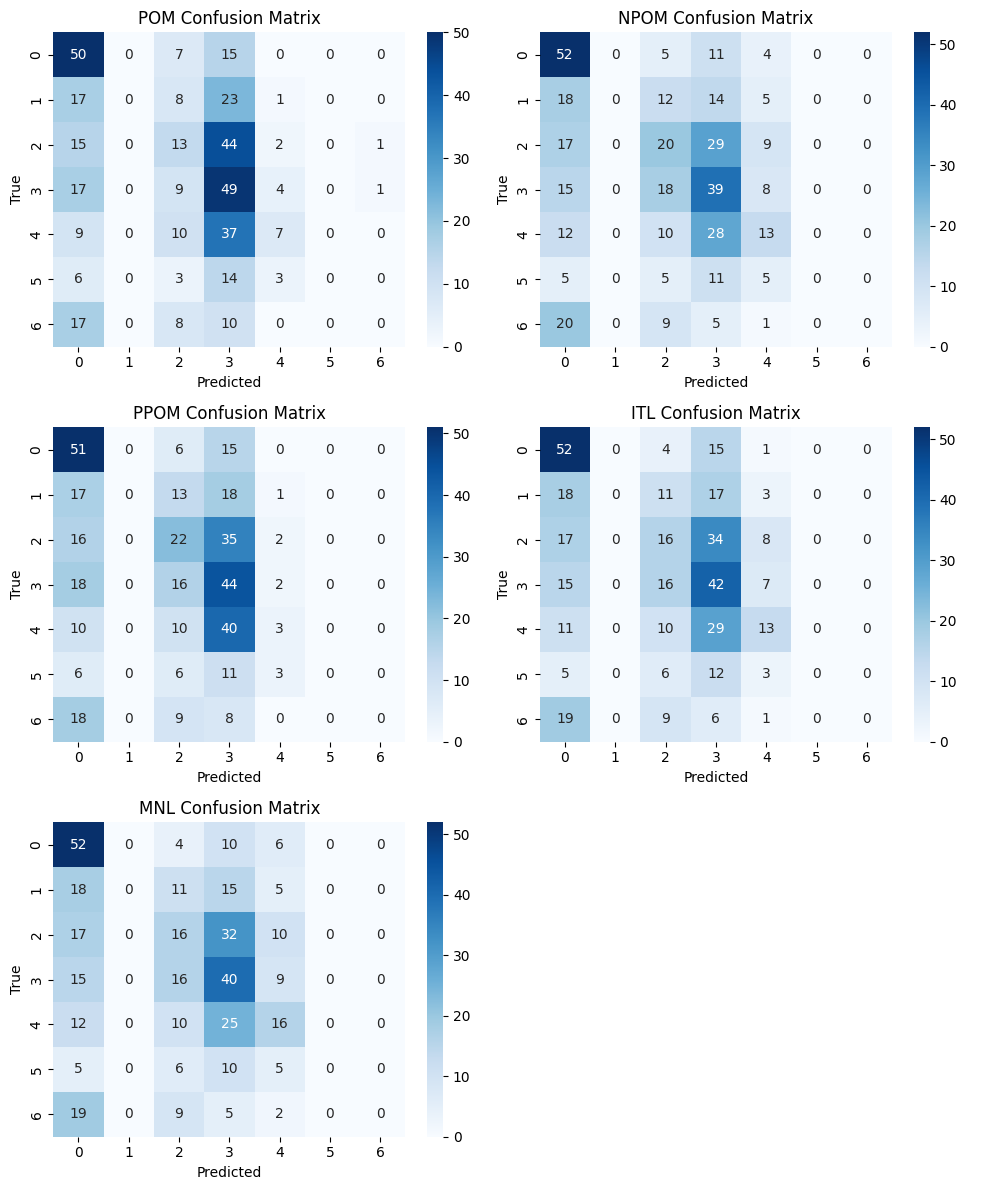

In [64]:
# Call plot_confusion_matrices
print("=== Confusion Matrices ===")
plot_confusion_matrices(
    test_df,
    pom_test_preds,
    npom_test_preds,
    ppom_test_preds,
    itl_test_preds,
    mnl_test_preds
)

# Statsmodels Models

In [65]:
def fit_statsmodels_pom(train_df, test_df):
    """
    Fit Proportional Odds Model using statsmodels OrderedModel.
    """
    print("=== Statsmodels Proportional Odds Model ===")

    # Prepare data - No constant for OrderedModel
    X_train = train_df[["Age_z", "Treatment"]]
    y_train = train_df["Severity"]

    X_test = test_df[["Age_z", "Treatment"]]
    y_test = test_df["Severity"]

    # Fit proportional odds model
    model = OrderedModel(y_train, X_train, distr='logit')
    result = model.fit(method='bfgs', disp=False)

    print("\nModel Summary:")
    print(result.summary())

    # Extract parameters
    # For OrderedModel: first are the predictor coefficients, then thresholds
    n_predictors = X_train.shape[1]
    beta_sm = result.params.iloc[:n_predictors]     # Age_z, Treatment
    thresholds = result.params.iloc[n_predictors:]  # Threshold parameters

    print(f"\nCoefficients:")
    print(f"  Age_z: {beta_sm.iloc[0]:.4f}")
    print(f"  Treatment: {beta_sm.iloc[1]:.4f}")
    print(f"\nThreshold parameters: {thresholds.values}")

    # Make predictions
    probs_train = result.predict(X_train)
    probs_test = result.predict(X_test)

    # Get predicted classes (highest probability)
    preds_train = np.argmax(probs_train, axis=1)
    preds_test = np.argmax(probs_test, axis=1)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, preds_train)
    test_acc = accuracy_score(y_test, preds_test)

    print(f"\nStatsmodels POM Accuracy:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test: {test_acc:.4f}")

    return result, train_acc, test_acc

In [66]:
# Statsmodels Proportional Odds Model
sm_pom_result, sm_pom_train_acc, sm_pom_test_acc = fit_statsmodels_pom(train_df, test_df)

=== Statsmodels Proportional Odds Model ===

Model Summary:
                             OrderedModel Results                             
Dep. Variable:               Severity   Log-Likelihood:                -2960.0
Model:                   OrderedModel   AIC:                             5936.
Method:            Maximum Likelihood   BIC:                             5979.
Date:                Sat, 07 Jun 2025                                         
Time:                        14:04:04                                         
No. Observations:                1600                                         
Df Residuals:                    1592                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age_z          0.4814      0.046     10.427      0.000       0.391     

In [67]:
def fit_statsmodels_itl(train_df, test_df):
    """
    Fit Independent Threshold Logit Model using statsmodels Logit.
    Each threshold j = 0..5 has its own binary logistic regression.
    """
    print("=== Statsmodels Independent Threshold Logit Model ===")

    # Prepare data - Add constant
    X_train = train_df[["Age_z", "Treatment"]]
    X_train = sm.add_constant(X_train)
    y_train = train_df["Severity"].astype(int)

    X_test = test_df[["Age_z", "Treatment"]]
    X_test = sm.add_constant(X_test)
    y_test = test_df["Severity"].astype(int)

    # Build and fit one Logit per threshold j = 0..5
    n_thresholds = len(np.unique(y_train)) - 1
    results = []
    for j in range(n_thresholds):
        # Binary indicator: Y <= j
        yj = (y_train <= j).astype(int)
        model_j = sm.Logit(yj, X_train)
        res_j = model_j.fit(disp=False)
        results.append(res_j)

        print(f"\nThreshold {j} Logit Summary:")
        print(res_j.summary())

    # Extract and print coefficients
    print("\nCoefficients per threshold:")
    for j, res_j in enumerate(results):
        intercept = res_j.params["const"]
        coef_age = res_j.params["Age_z"]
        coef_trt = res_j.params["Treatment"]
        print(
            f"  Threshold {j}:  intercept = {intercept:.4f},  "
            f"Age_z = {coef_age:.4f},  Treatment = {coef_trt:.4f}"
        )

    # Predict P(Y <= j) for each threshold
    prob_train = np.column_stack([res.predict(X_train) for res in results])
    prob_test = np.column_stack([res.predict(X_test) for res in results])

    # Enforce monotonicity: P(Y <= j) >= P(Y <= j-1)
    prob_train = np.maximum.accumulate(prob_train, axis=1)
    prob_test = np.maximum.accumulate(prob_test, axis=1)

    # Add boundaries 0 at j=-1 and 1 at j=n_thresholds
    zeros_tr = np.zeros((prob_train.shape[0], 1))
    ones_tr = np.ones((prob_train.shape[0], 1))
    cdf_train= np.hstack([zeros_tr, prob_train, ones_tr])

    zeros_te = np.zeros((prob_test.shape[0], 1))
    ones_te = np.ones((prob_test.shape[0], 1))
    cdf_test = np.hstack([zeros_te, prob_test, ones_te])

    # Compute 7-category probabilities by differencing adjacent CDF values
    probs_train = cdf_train[:, 1:] - cdf_train[:, :-1]
    probs_test = cdf_test[:, 1:] - cdf_test[:, :-1]

    # Make predictions
    preds_train = np.argmax(probs_train, axis=1)
    preds_test = np.argmax(probs_test, axis=1)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, preds_train)
    test_acc = accuracy_score(y_test, preds_test)

    print(f"\nStatsmodels ITL Accuracy:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test: {test_acc:.4f}")

    return results, train_acc, test_acc

In [68]:
# Statsmodels Independent Threshold Logit Model
sm_itl_result, sm_itl_train_acc, sm_itl_test_acc = fit_statsmodels_itl(train_df, test_df)

=== Statsmodels Independent Threshold Logit Model ===

Threshold 0 Logit Summary:
                           Logit Regression Results                           
Dep. Variable:               Severity   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1597
Method:                           MLE   Df Model:                            2
Date:                Sat, 07 Jun 2025   Pseudo R-squ.:                  0.1706
Time:                        14:04:04   Log-Likelihood:                -623.07
converged:                       True   LL-Null:                       -751.19
Covariance Type:            nonrobust   LLR p-value:                 2.277e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1484      0.120    -17.854      0.000      -2.384      -1.913
Age_z         -1.2161      0.088    -13.758      

In [69]:
def fit_statsmodels_mnl(train_df, test_df):
    """
    Fit Multinomial Logit Model using statsmodels MNLogit.
    """
    print("=== Statsmodels Multinomial Logit Model ===")

    # Prepare data - Add constant
    X_train = train_df[["Age_z", "Treatment"]]
    X_train = sm.add_constant(X_train)
    y_train = train_df["Severity"]

    X_test = test_df[["Age_z", "Treatment"]]
    X_test = sm.add_constant(X_test)
    y_test = test_df["Severity"]

    # Fit multinomial logit model
    model = MNLogit(y_train, X_train)
    result = model.fit(
        method='newton',
        maxiter=300,
        full_output=True,
        disp=False
    )

    print("\nModel Summary:")
    print(result.summary())

    # Extract parameters (K-1 sets of coefficients)
    params = result.params
    print(f"\nShape of parameters: {params.shape}")

    # Make predictions
    probs_train = result.predict(X_train)
    probs_test = result.predict(X_test)

    preds_train = np.argmax(probs_train, axis=1)
    preds_test = np.argmax(probs_test, axis=1)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, preds_train)
    test_acc = accuracy_score(y_test, preds_test)

    print(f"\nStatsmodels MNL Accuracy:")
    print(f"  Train: {train_acc:.4f}")
    print(f"  Test: {test_acc:.4f}")

    return result, train_acc, test_acc

In [70]:
# Statsmodels Multinomial Logit Model
sm_mnl_result, sm_mnl_train_acc, sm_mnl_test_acc = fit_statsmodels_mnl(train_df, test_df)

=== Statsmodels Multinomial Logit Model ===

Model Summary:
                          MNLogit Regression Results                          
Dep. Variable:               Severity   No. Observations:                 1600
Model:                        MNLogit   Df Residuals:                     1582
Method:                           MLE   Df Model:                           12
Date:                Sat, 07 Jun 2025   Pseudo R-squ.:                 0.07610
Time:                        14:04:05   Log-Likelihood:                -2787.0
converged:                       True   LL-Null:                       -3016.5
Covariance Type:            nonrobust   LLR p-value:                 1.107e-90
Severity=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4372      0.151      2.890      0.004       0.141       0.734
Age_z          1.1166      0.119      9.392      0.000       0.884     

# Unified Summary

In [71]:
def summarize_all_models():
    """
    Print a unified summary of parameters and train/test accuracies
    for all five PyMC models (POM, NPOM, PPOM, ITL, MNL)
    and both Statsmodels models (POM, MNL).
    """
    # === PyMC POM ===
    print("=== PyMC Proportional Odds Model (POM) Posterior-Mean Summary ===")
    print(f"  Age_z coefficient: {beta_pom_mean[0]:.4f}")
    print(f"  Treatment coefficient: {beta_pom_mean[1]:.4f}")
    print(f"  Thresholds: {alphas_pom_mean.round(4).tolist()}")
    print(f"  Training set accuracy: {pom_train_acc:.4f}")
    print(f"  Test set accuracy: {pom_test_acc:.4f}")
    print()

    # === PyMC NPOM ===
    print("=== PyMC Non-Proportional Odds Model (NPOM) Posterior-Mean Summary ===")
    for j in range(6):
        slope_age = betas_np_mean[j, 0]
        slope_treat = betas_np_mean[j, 1]
        print(
            f"  Threshold {j}->{j+1} slopes:  "
            f"Age_z = {slope_age:.4f},  Treatment = {slope_treat:.4f}"
        )
    print(f"  Thresholds: {alphas_np_mean.round(4).tolist()}")
    print(f"  Training set accuracy: {npom_train_acc:.4f}")
    print(f"  Test set accuracy: {npom_test_acc:.4f}")
    print()

    # === PyMC PPOM ===
    print("=== PyMC Partial Proportional Odds Model (PPOM) Posterior-Mean Summary ===")
    for j in range(6):
        slope_age = beta_age_ppom_mean[j]
        print(f"  Threshold {j}->{j+1} slope for Age_z: {slope_age:.4f}")
    print(f"  Treatment slope (shared): {beta_trt_ppom_mean:.4f}")
    print(f"  Thresholds: {alphas_ppom_mean.round(4).tolist()}")
    print(f"  Training set accuracy: {ppom_train_acc:.4f}")
    print(f"  Test set accuracy: {ppom_test_acc:.4f}")
    print()

    # === PyMC ITL ===
    print("=== PyMC Independent Threshold Logit Model (ITL) Posterior-Mean Summary ===")
    for j in range(6):
        intercept_j = alpha_itl_mean[j]
        coef_age = beta_itl_mean[j, 0]
        coef_treatment = beta_itl_mean[j, 1]
        print(
            f"  Threshold {j} intercept = {intercept_j:.4f},  "
            f"Age_z = {coef_age:.4f},  Treatment = {coef_treatment:.4f}"
        )
    print(f"  Training set accuracy: {itl_train_acc:.4f}")
    print(f"  Test set accuracy: {itl_test_acc:.4f}")
    print()

    # === PyMC MNL ===
    print("=== PyMC Multinomial Logit Model (MNL) Posterior-Mean Summary ===")
    for j in range(1, 7):
        intercept_j = alpha_mnl_mean[j - 1]
        coef_age = beta_mnl_mean[j - 1, 0]
        coef_treat = beta_mnl_mean[j - 1, 1]
        print(
            f"  Category {j} vs. 0:  intercept = {intercept_j:.4f},  "
            f"Age_z = {coef_age:.4f},  Treatment = {coef_treat:.4f}"
        )
    print(f"  Training set accuracy: {mnl_train_acc:.4f}")
    print(f"  Test set accuracy: {mnl_test_acc:.4f}")
    print()

    # === Statsmodels POM ===
    print("=== Statsmodels Proportional Odds Model (SM POM) Summary ===")
    sm_params_pom = sm_pom_result.params
    beta_sm_age = sm_params_pom.iloc[0]
    beta_sm_treat = sm_params_pom.iloc[1]
    thresholds_sm = sm_params_pom.iloc[2:].values.round(4).tolist()
    print(f"  Age_z coefficient: {beta_sm_age:.4f}")
    print(f"  Treatment coefficient: {beta_sm_treat:.4f}")
    print(f"  Threshold parameters: {thresholds_sm}")
    print(f"  Training set accuracy: {sm_pom_train_acc:.4f}")
    print(f"  Test set accuracy: {sm_pom_test_acc:.4f}")
    print()

    # === Statsmodels ITL ===
    print("=== Statsmodels Independent Threshold Logit Model (SM ITL) Summary ===")
    for j, res_j in enumerate(sm_itl_result):
        intercept_j = res_j.params["const"]
        coef_age = res_j.params["Age_z"]
        coef_treat = res_j.params["Treatment"]
        print(
            f"  Threshold {j}:  intercept = {intercept_j:.4f},  "
            f"Age_z = {coef_age:.4f},  Treatment = {coef_treat:.4f}"
        )
    print(f"  Training set accuracy: {sm_itl_train_acc:.4f}")
    print(f"  Test set accuracy: {sm_itl_test_acc:.4f}")
    print()

    # === Statsmodels MNL ===
    print("=== Statsmodels Multinomial Logit Model (SM MNL) Summary ===")
    sm_params_mnl = sm_mnl_result.params
    for category in sm_params_mnl.columns:
        intercept = sm_params_mnl.loc["const", category]
        coef_age = sm_params_mnl.loc["Age_z", category]
        coef_treat = sm_params_mnl.loc["Treatment", category]
        print(
            f"  Category {int(category)+1} vs. 0:  intercept = {intercept:.4f},  "
            f"Age_z = {coef_age:.4f},  Treatment = {coef_treat:.4f}"
        )
    print(f"  Training set accuracy: {sm_mnl_train_acc:.4f}")
    print(f"  Test set accuracy: {sm_mnl_test_acc:.4f}")

In [72]:
# Summarize all models
summarize_all_models()

=== PyMC Proportional Odds Model (POM) Posterior-Mean Summary ===
  Age_z coefficient: 0.4812
  Treatment coefficient: 0.0759
  Thresholds: [-1.5179, -0.7873, 0.0645, 0.9485, 1.8755, 2.504]
  Training set accuracy: 0.2681
  Test set accuracy: 0.2975

=== PyMC Non-Proportional Odds Model (NPOM) Posterior-Mean Summary ===
  Threshold 0->1 slopes:  Age_z = 1.0896,  Treatment = -0.3493
  Threshold 1->2 slopes:  Age_z = 0.7962,  Treatment = -0.1307
  Threshold 2->3 slopes:  Age_z = 0.5457,  Treatment = 0.0310
  Threshold 3->4 slopes:  Age_z = 0.2611,  Treatment = 0.3260
  Threshold 4->5 slopes:  Age_z = -0.2723,  Treatment = 0.5028
  Threshold 5->6 slopes:  Age_z = -0.9497,  Treatment = 1.0735
  Thresholds: [-2.0299, -1.0153, -0.0319, 0.9769, 1.9866, 3.1765]
  Training set accuracy: 0.2863
  Test set accuracy: 0.3100

=== PyMC Partial Proportional Odds Model (PPOM) Posterior-Mean Summary ===
  Threshold 0->1 slope for Age_z: 1.0956
  Threshold 1->2 slope for Age_z: 0.7724
  Threshold 2->3 s

# VGAM Models

In [73]:
# Save the data
train_df.to_csv("/content/train_df.csv", index=False)
test_df.to_csv("/content/test_df.csv", index=False)

In [74]:
# Load the R magic
%load_ext rpy2.ipython

In [75]:
# Install VGAM
%%R
install.packages("VGAM", repos="https://cloud.r-project.org")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/VGAM_1.1-13.tar.gz'
Content type 'application/x-gzip' length 1710222 bytes (1.6 MB)
downloaded 1.6 MB


The downloaded source packages are in
	‘/tmp/RtmpPMhijg/downloaded_packages’


In [76]:
%%R
library(VGAM)

# Read in the data
train_df <- read.csv("/content/train_df.csv", stringsAsFactors=FALSE)
test_df <- read.csv("/content/test_df.csv", stringsAsFactors=FALSE)

train_df$Severity <- factor(train_df$Severity, levels=0:6)
train_df$Treatment <- factor(train_df$Treatment, levels=c(0, 1))
test_df$Severity <- factor(test_df$Severity, levels=0:6)
test_df$Treatment <- factor(test_df$Treatment, levels=c(0, 1))

Loading required package: stats4
Loading required package: splines


In [77]:
%%R
# Fit Proportional Odds Model (POM)
vglm_pom <- vglm(
  Severity ~ Age_z + Treatment,
  family=cumulative(parallel=TRUE, link="logitlink"),
  data=train_df,
  trace=FALSE
)

coeffs_pom <- Coef(vglm_pom, matrix=FALSE)
alpha_names <- paste0("alpha", 1:6)
beta_names <- c("Age_z", "Treatment1")
pom_thresholds <- coeffs_pom[alpha_names]
pom_betas <- coeffs_pom[beta_names]

In addition: Warning message:
In eval(slot(family, "initialize")) :
  response should be ordinal---see ordered()


In [78]:
%%R
# Fit Non-Proportional Odds Model (NPOM)
vglm_npom <- vglm(
  Severity ~ Age_z + Treatment,
  family=cumulative(parallel=FALSE, link="logitlink"),
  data=train_df,
  trace=FALSE
)

coeffs_npom <- Coef(vglm_npom, matrix=FALSE)
npom_thresholds <- coeffs_npom[alpha_names]

npom_betas <- matrix(
    NA,
    nrow=6L,
    ncol=2L,
    dimnames=list(paste0("th", 1:6), beta_names)
)

for (j in seq_len(6L)) {
  npom_betas[j, "Age_z"] <- coeffs_npom[paste0("Age_z:", j)]
  npom_betas[j, "Treatment1"] <- coeffs_npom[paste0("Treatment1:", j)]
}

In addition: There were 45 warnings (use warnings() to see them)


In [79]:
%%R
# Fit Multinomial Logit Model (MNL)
vglm_mnl <- vglm(
  Severity ~ Age_z + Treatment,
  family=multinomial(refLevel=1),
  data=train_df,
  trace=FALSE
)

coeffs_mnl <- Coef(vglm_mnl, matrix=FALSE)

In [80]:
%%R
# Function to compute train/test accuracy
predict_class <- function(fit_obj, newdata) {
  prob_matrix <- predict(fit_obj, newdata=newdata, type="response")
  preds <- apply(prob_matrix, 1, which.max) - 1L
  return(preds)
}

# POM predictions and accuracies
train_preds_pom <- predict_class(vglm_pom, train_df)
test_preds_pom <- predict_class(vglm_pom, test_df)

pom_train_acc <- mean(train_preds_pom == as.integer(as.character(train_df$Severity)))
pom_test_acc <- mean(test_preds_pom == as.integer(as.character(test_df$Severity)))

# NPOM predictions and accuracies
train_preds_npom <- predict_class(vglm_npom, train_df)
test_preds_npom <- predict_class(vglm_npom, test_df)

npom_train_acc <- mean(train_preds_npom == as.integer(as.character(train_df$Severity)))
npom_test_acc <- mean(test_preds_npom == as.integer(as.character(test_df$Severity)))

# MNL predictions and accuracies
train_preds_mnl <- predict_class(vglm_mnl, train_df)
test_preds_mnl <- predict_class(vglm_mnl, test_df)

mnl_train_acc <- mean(train_preds_mnl == as.integer(as.character(train_df$Severity)))
mnl_test_acc <- mean(test_preds_mnl == as.integer(as.character(test_df$Severity)))

In [81]:
%%R
# Save coefficients
# POM
pom_df <- data.frame(
    param=names(coeffs_pom),
    estimate=as.numeric(coeffs_pom),
    row.names=NULL,
    stringsAsFactors=FALSE
)

write.csv(
    pom_df,
    file="/content/pom_coeffs.csv",
    row.names=FALSE
)

# NPOM
npom_df <- data.frame(
    param=names(coeffs_npom),
    estimate=as.numeric(coeffs_npom),
    row.names=NULL,
    stringsAsFactors=FALSE
)

write.csv(
    npom_df,
    file="/content/npom_coeffs.csv",
    row.names=FALSE
)

# MNL
mnl_df <- data.frame(
  param=names(coeffs_mnl),
  estimate=as.numeric(coeffs_mnl),
  row.names=NULL,
  stringsAsFactors=FALSE
)

write.csv(
    mnl_df,
    file="/content/mnl_coeffs.csv",
    row.names=FALSE
)

In [82]:
%%R
# Save accuracies
acc_df <- data.frame(
    model=c("POM", "NPOM", "MNL"),
    train_acc=c(pom_train_acc, npom_train_acc, mnl_train_acc),
    test_acc=c(pom_test_acc, npom_test_acc, mnl_test_acc),
    stringsAsFactors=FALSE
)

write.csv(
    acc_df,
    file="/content/ordinal_accuracies.csv",
    row.names=FALSE
)

# Save model summaries to text files
capture.output(
    summary(vglm_pom),
    file="/content/pom_summary.txt"
)

capture.output(
    summary(vglm_npom),
    file="/content/npom_summary.txt"
)

capture.output(
    summary(vglm_mnl),
    file="/content/mnl_summary.txt"
)

In addition: Warning message:
In eval(expr) : some probabilities are very close to 0


In [83]:
# Read POM coefficients
pom_coeffs = pd.read_csv("/content/pom_coeffs.csv")
print("POM Coefficients:")
print(pom_coeffs)

POM Coefficients:
           param  estimate
0  (Intercept):1 -1.518384
1  (Intercept):2 -0.788332
2  (Intercept):3  0.062765
3  (Intercept):4  0.947007
4  (Intercept):5  1.873708
5  (Intercept):6  2.498548
6          Age_z -0.481411
7     Treatment1 -0.074646


In [84]:
# Read NPOM coefficients
npom_coeffs = pd.read_csv("/content/npom_coeffs.csv")
print("NPOM Coefficients:")
print(npom_coeffs)

NPOM Coefficients:
            param  estimate
0   (Intercept):1 -1.708583
1   (Intercept):2 -0.896235
2   (Intercept):3 -0.040402
3   (Intercept):4  0.958906
4   (Intercept):5  1.914340
5   (Intercept):6  2.807817
6         Age_z:1 -0.995880
7         Age_z:2 -0.703631
8         Age_z:3 -0.522440
9         Age_z:4 -0.236561
10        Age_z:5  0.193349
11        Age_z:6  0.629999
12   Treatment1:1  0.378986
13   Treatment1:2  0.105088
14   Treatment1:3 -0.019227
15   Treatment1:4 -0.346138
16   Treatment1:5 -0.440946
17   Treatment1:6 -0.968631


In [85]:
# Read MNL coefficients
mnl_coeffs = pd.read_csv("/content/mnl_coeffs.csv")
print("MNL Coefficients:")
print(mnl_coeffs)

MNL Coefficients:
            param  estimate
0   (Intercept):1  0.437210
1   (Intercept):2  0.812086
2   (Intercept):3  0.899190
3   (Intercept):4  0.407736
4   (Intercept):5 -0.217122
5   (Intercept):6 -0.845508
6         Age_z:1  1.116641
7         Age_z:2  1.248002
8         Age_z:3  1.637860
9         Age_z:4  1.729727
10        Age_z:5  1.622828
11        Age_z:6  0.319394
12   Treatment1:1 -0.750469
13   Treatment1:2 -0.631893
14   Treatment1:3 -0.883747
15   Treatment1:4 -0.435827
16   Treatment1:5 -0.843758
17   Treatment1:6  0.573268


In [86]:
# Read train/test accuracies for VGAM models
acc = pd.read_csv("/content/ordinal_accuracies.csv")
print("Train/Test Accuracies:")
print(acc)

Train/Test Accuracies:
  model  train_acc  test_acc
0   POM    0.27000    0.2975
1  NPOM    0.28500    0.2950
2   MNL    0.28125    0.3100


In [87]:
# Display the POM summary
print("POM Summary:")
with open("/content/pom_summary.txt") as f:
    print(f.read())

POM Summary:

Call:
vglm(formula = Severity ~ Age_z + Treatment, family = cumulative(parallel = TRUE, 
    link = "logitlink"), data = train_df, trace = FALSE)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1 -1.51838    0.07878 -19.274   <2e-16 ***
(Intercept):2 -0.78833    0.07018 -11.234   <2e-16 ***
(Intercept):3  0.06277    0.06730   0.933    0.351    
(Intercept):4  0.94701    0.07142  13.259   <2e-16 ***
(Intercept):5  1.87371    0.08479  22.099   <2e-16 ***
(Intercept):6  2.49855    0.10118  24.694   <2e-16 ***
Age_z         -0.48141    0.04572 -10.530   <2e-16 ***
Treatment1    -0.07465    0.08829  -0.845    0.398    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  6 

Names of linear predictors: logitlink(P[Y<=1]), logitlink(P[Y<=2]), 
logitlink(P[Y<=3]), logitlink(P[Y<=4]), logitlink(P[Y<=5]), logitlink(P[Y<=6])

Residual deviance: 5920.055 on 9592 degrees of freedom

Log-likelihood: -2960.

In [88]:
# Display the NPOM summary
print("NPOM Summary:")
with open("/content/npom_summary.txt") as f:
    print(f.read())

NPOM Summary:

Call:
vglm(formula = Severity ~ Age_z + Treatment, family = cumulative(parallel = FALSE, 
    link = "logitlink"), data = train_df, trace = FALSE)

Coefficients: 
                Estimate Std. Error    z value Pr(>|z|)    
(Intercept):1 -1.709e+00  6.936e-02 -2.464e+01  < 2e-16 ***
(Intercept):2 -8.962e-01  6.934e-02 -1.293e+01  < 2e-16 ***
(Intercept):3 -4.040e-02  5.543e-02         NA       NA    
(Intercept):4  9.589e-01  1.042e-06  9.200e+05  < 2e-16 ***
(Intercept):5  1.914e+00  6.455e-07  2.966e+06  < 2e-16 ***
(Intercept):6  2.808e+00  5.261e-07  5.337e+06  < 2e-16 ***
Age_z:1       -9.959e-01  3.376e-06 -2.950e+05  < 2e-16 ***
Age_z:2       -7.036e-01  4.406e-06 -1.597e+05  < 2e-16 ***
Age_z:3       -5.224e-01  7.723e-07 -6.765e+05  < 2e-16 ***
Age_z:4       -2.366e-01  5.549e-07 -4.264e+05  < 2e-16 ***
Age_z:5        1.933e-01  3.571e-07  5.415e+05  < 2e-16 ***
Age_z:6        6.300e-01  2.795e-07  2.254e+06  < 2e-16 ***
Treatment1:1   3.790e-01  6.936e-02  5.464

In [89]:
# Display the MNL summary
print("MNL Summary:")
with open("/content/mnl_summary.txt") as f:
    print(f.read())

MNL Summary:

Call:
vglm(formula = Severity ~ Age_z + Treatment, family = multinomial(refLevel = 1), 
    data = train_df, trace = FALSE)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1   0.4372     0.1513   2.890 0.003854 ** 
(Intercept):2   0.8121     0.1421   5.716 1.09e-08 ***
(Intercept):3   0.8992     0.1418   6.343 2.25e-10 ***
(Intercept):4   0.4077     0.1545   2.639 0.008305 ** 
(Intercept):5  -0.2171     0.1786  -1.215 0.224180    
(Intercept):6  -0.8455     0.2009  -4.208 2.58e-05 ***
Age_z:1         1.1166     0.1189   9.392  < 2e-16 ***
Age_z:2         1.2480     0.1098  11.367  < 2e-16 ***
Age_z:3         1.6379     0.1134  14.445  < 2e-16 ***
Age_z:4         1.7297     0.1190  14.540  < 2e-16 ***
Age_z:5         1.6228     0.1440  11.269  < 2e-16 ***
Age_z:6         0.3194     0.1236   2.585 0.009735 ** 
Treatment1:1   -0.7505     0.1980  -3.790 0.000151 ***
Treatment1:2   -0.6319     0.1789  -3.531 0.000413 ***
Treatment1:3   -0.883